# Solving Garden Optimization Problem with the QAOA algorithm

![Garden](planting.jpg)

In this tutorial, we will demonstrate how to generate an instance of the Garden Optimization Problem [[1]](#ref) and solve it using the Quantum Approximate Optimization Algorithm (QAOA) [[2]](#ref).

To achieve this, we will be utilizing [Qiskit](https://qiskit.org/), a quantum development toolkit that offers a variety of implementations of common quantum optimization techniques including QAOA. Our primary objective is to gain a fundamental understanding of QAOA's optimization algorithm and how it can be utilized to solve combinatorial optimization problems.

For additional technical details and examples, we recommend referring to the Qiskit documentation and the optimization tutorials page [[3]](#ref).

## Table of Contents

* [Garden Optimization Problem](#qubo)
* [Classical solver](#exact)
* [QAOA optimization](#qaoa)
* [References](#ref)

## Relevant packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

# import sys, os
# sys.path.append(os.path.abspath("<full path to GardenOptimizationProblem.py>"))
from GardenOptimizationProblem import GardenOptimizationProblem
from sampling import sample_most_likely

from qiskit import Aer, execute
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.algorithms import QAOA
from qiskit.algorithms.optimizers import COBYLA
from qiskit.algorithms import NumPyMinimumEigensolver

%matplotlib inline

## <a class="anchor" id="qubo"> </a>Garden Optimization Problem

The goal of the Garden Optimization Problem (GOP) [[1]](#ref) is to find an optimal placement of `n` plants into `n` garden pots (one plant per pot). Each plant belongs to a particular species, and in fact, some species like to be placed next to each other, while others do not. An optimal placement of the `n` plants is thus a placement that maximizes the number of friendly relationships between neighboring pots.

In addition, the following constraints are added to influence the optimal plant placement:

1. "*Fill all pots*": Each of the `n` pots must be filled with exactly one plant.
2. "*Place all plants*": All of the `n` plants are placed in the garden.
3. "*Always look on the bright side of life*": (additional level of complexity) Large plants should not overshadow smaller plants.

Workshop participants are welcome to learn more details about GOP and follow all the steps necessary to complete the binary problem formulation as provided in this [Tutorial](https://jugit.fz-juelich.de/qip/springschool2023/-/blob/main/garden_DWAVE/garden_DWAVE.ipynb). 
For the purpose of this tutorial, we skip this step and already provide the final binary problem formulation in the class `GardenOptimizationProblem` on only concentrate on the actual model setup.
When choosing the problem parameters, please keep in mind the limitation on the maximum problem size (number of variables) that can be treated with quantum simulators. To be able to complete the tutorial with your local PC, the number of the variables (= the number of qubits) should not exceed 24.

The GOP setup consists of 2 steps: defining the arrangement of the plant pots and selecting the plant species that should find its best location in the pots. For simplicity, let us consider the simplest $2 \times 2$ arrangement of pots. Taking into account the 4 possible different types of plants that can be chosen to be placed in the pots, our optimization problem has a total of 16 variables.

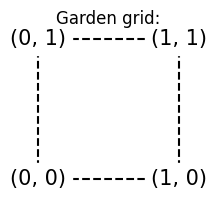

In [2]:
cols = 2
rows = 2

model = GardenOptimizationProblem()
model.build_garden(cols, rows, verbose=True)

The collection of plants we are going to cultivate is already preset in the `GardenOptimizationProblem` instance.
Let us randomly select 4 plants.

In [3]:
species, count, size = model.pick_random_plants(replacement=False, seed=42)
model.get_plants(species, count, size, companions="./companions.csv", verbose=True)

Companions matrix:


,Paprika,Carrot,Oregano,Basil
Paprika,-1,-1,-1,-1
Carrot,-1,-1,0,0
Oregano,-1,0,-1,-1
Basil,-1,0,-1,-1


The companion matrix tells us which plants a given species prefers to have as neighbors (-1: like, 0: neutral, 1: dislike).

The last step in the problem initialization is to formulate the Quadratic Unconstrained Binary Optimization (QUBO) problem. The QUBO formulation of GOP contains 3 parameters (Lagrangian coefficients due to the chosen constraints).

In [4]:
# Lagrangian parameters (lambda_1, lambda_2, lambda_3)
lagrangian_params = (2, 2, 1)

# output is the DOCplex binary optimization model
mdl = model.build_qubo(*lagrangian_params, verbose=False)

For convenience, we store the QUBO problem in the [DOcplex model](https://www.ibm.com/docs/en/icos/12.9.0?topic=docplex-python-modeling-api) format. This format is widely used to execute the IBM Decision Optimization CPLEX optimizer from Python and has an interface to Qiskit.

In [5]:
mdl.prettyprint()

// This file has been generated by DOcplex
// model name is: Garden Optimization Problem
// single vars section
dvar bool x_0;
dvar bool x_1;
dvar bool x_2;
dvar bool x_3;
dvar bool x_4;
dvar bool x_5;
dvar bool x_6;
dvar bool x_7;
dvar bool x_8;
dvar bool x_9;
dvar bool x_10;
dvar bool x_11;
dvar bool x_12;
dvar bool x_13;
dvar bool x_14;
dvar bool x_15;

minimize
 [ - 4 x_0^2 + 4 x_0*x_1 + 4 x_0*x_2 + 4 x_0*x_3 + 3 x_0*x_4 - x_0*x_5
 - x_0*x_6 - x_0*x_7 + 3 x_0*x_8 - x_0*x_9 - x_0*x_10 - x_0*x_11 + 4 x_0*x_12
 - 4 x_1^2 + 4 x_1*x_2 + 4 x_1*x_3 - x_1*x_4 + 3 x_1*x_5 - x_1*x_8 + 3 x_1*x_9
 + 4 x_1*x_13 - 3 x_2^2 + 4 x_2*x_3 - x_2*x_4 + 3 x_2*x_6 - x_2*x_7 - x_2*x_8
 + 3 x_2*x_10 - x_2*x_11 + 4 x_2*x_14 - 3 x_3^2 - x_3*x_4 - x_3*x_6
 + 3 x_3*x_7 - x_3*x_8 - x_3*x_10 + 3 x_3*x_11 + 4 x_3*x_15 - 3 x_4^2
 + 4 x_4*x_5 + 4 x_4*x_6 + 4 x_4*x_7 + 4 x_4*x_8 + 3 x_4*x_12 - x_4*x_13
 - x_4*x_14 - x_4*x_15 - 3 x_5^2 + 4 x_5*x_6 + 4 x_5*x_7 + 4 x_5*x_9
 - x_5*x_12 + 3 x_5*x_13 - 4 x_6^2 + 4 x_6*x_7

## <a class="anchor" id="exact"> </a>Classical solver

The chosen problem size allows us to quickly estimate the solution with the simplest "brute-force" search. 

<font size="4"><span style='background:yellow'>**Exercise:**</span></font> Implement the brute-force search for the Garden Optimization Problem given the problem objective/cost function can be computed with the `model.evaluate_objective(x)` method, where `x` is a solution candidate (specified as a list of binary bits). How many solutions do you get? How does the execution time scales with the problem size?

Hint: The "brute-force" search essentially means to check the energies of all possible problem solutions and select the lowest ones. Use the Numpy routine `np.binary_repr()` to obtain the binary strings representing solutions. Additionally, to match the problem binary encoding, the strings should be reverted. 

<font size="4"><span style='background:yellow'>**Solution:**</span></font> Brute-force search

In [6]:
def brute_force(max_cost=10.0):
    """Brute force search of optimal solutions"""

    best_cost = np.infty
    solutions = []

    n = model.num_vars
    for b in range(2**n):
        x = [int(t) for t in reversed(np.binary_repr(b, width=n))]
        cost = model.evaluate_objective(x)
        if cost < best_cost:
            best_cost = cost
        # collect only solutions with cost < max_cost
        if cost < max_cost:
            solutions.append({"x": x, "cost": cost})

    best_solutions = []
    for x in solutions:
        if np.isclose(x["cost"], best_cost):
            best_solutions.append(x)

    return best_solutions

In [7]:
brute_force_solutions = brute_force()
for s in brute_force_solutions:
    print(s)

{'x': [0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0], 'cost': 1.0}
{'x': [1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0], 'cost': 1.0}
{'x': [0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1], 'cost': 1.0}
{'x': [1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1], 'cost': 1.0}


We see that the problem has multiple degenerate solutions. One of the optimal plant arrangements is visualized below.

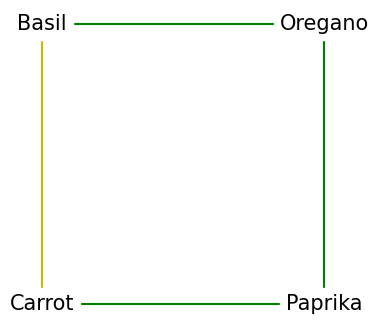

In [8]:
model.plot_solution(brute_force_solutions[0]["x"])

Obviously, brute-force search quickly becomes intractable due to the exponential growth of the configuration space. Therefore, for larger problems, one must use an efficient classical solver, e.g., this can be done very easily with the `solve()` method of our DOcplex model, provided that IBM's CPLEX solver is available.

In [ ]:
#----------------------------------------------------------------
# Warning: The CPLEX solver is not installed on the JUNIQ cloud!
#
# The code below would work on you local PC if you followed 
# the installation instructions mentioned in README
#----------------------------------------------------------------

# mdl.solve()
# mdl.print_solution()

# x = dict()
# for v in mdl.iter_binary_vars():
#     x[v.index] = v.solution_value

# # Visualize the classical solver solution
# model.plot_solution(x)

## <a class="anchor" id="qaoa"> </a>QAOA optimization

QAOA is a popular hybrid quantum-classical variational algorithm that is designed for solving the combinatorial optimization problems on NISQ devices. Here is the QAOA algorithm flowchart that we are going to implement below using Qiskit facilities.

![QAOA](qaoa.jpg)

### From QUBO to Ising model

To setup the QAOA quantum algorithm, we need to convert the binary problem into the corresponding Ising Hamiltonian, which is further transformed into a quantum circuit. Qiskit automates this conversion:

In [10]:
from qiskit_optimization.translators import from_docplex_mp

qp = from_docplex_mp(mdl)
qubitOp, offset = qp.to_ising()

print("Offset:", offset)
print("Ising Hamiltonian:\n", str(qubitOp))

Offset: 28.0
Ising Hamiltonian:
 -2.0 * IIIIIIIIIIIIIIIZ
+ 1.0 * IIIIIIIIIIIIIIZZ
- 3.0 * IIIIIIIIIIIIIIZI
+ 1.0 * IIIIIIIIIIIIIZIZ
- 3.0 * IIIIIIIIIIIIIZII
+ 1.0 * IIIIIIIIIIIIIZZI
+ 1.0 * IIIIIIIIIIIIZIIZ
- 3.0 * IIIIIIIIIIIIZIII
+ 1.0 * IIIIIIIIIIIIZIZI
+ 1.0 * IIIIIIIIIIIIZZII
+ 0.75 * IIIIIIIIIIIZIIIZ
- 2.5 * IIIIIIIIIIIZIIII
- 0.25 * IIIIIIIIIIIZIIZI
- 0.25 * IIIIIIIIIIIZIZII
- 0.25 * IIIIIIIIIIIZZIII
- 0.25 * IIIIIIIIIIZIIIIZ
- 3.5 * IIIIIIIIIIZIIIII
+ 0.75 * IIIIIIIIIIZIIIZI
+ 1.0 * IIIIIIIIIIZZIIII
- 0.25 * IIIIIIIIIZIIIIIZ
- 2.5 * IIIIIIIIIZIIIIII
+ 0.75 * IIIIIIIIIZIIIZII
- 0.25 * IIIIIIIIIZIIZIII
+ 1.0 * IIIIIIIIIZIZIIII
+ 1.0 * IIIIIIIIIZZIIIII
- 0.25 * IIIIIIIIZIIIIIIZ
- 2.5 * IIIIIIIIZIIIIIII
- 0.25 * IIIIIIIIZIIIIZII
+ 0.75 * IIIIIIIIZIIIZIII
+ 1.0 * IIIIIIIIZIIZIIII
+ 1.0 * IIIIIIIIZIZIIIII
+ 1.0 * IIIIIIIIZZIIIIII
+ 0.75 * IIIIIIIZIIIIIIIZ
- 2.0 * IIIIIIIZIIIIIIII
- 0.25 * IIIIIIIZIIIIIIZI
- 0.25 * IIIIIIIZIIIIIZII
- 0.25 * IIIIIIIZIIIIZIII
+ 1.0 * IIIIIIIZIIIZIIII
- 

`qubitOp` contains representation of the objective function in terms of the Pauli's `Z` and `ZZ` operators. `offset` is a constant (physically irrelevant energy shift) that is basically required to obtain the absolute value of the objective function for comparison with classical methods.

### QAOA ansatz

The next step is to construct the QAOA variational ansatz. This can be done explicitly using the basic Qiskit quantum circuit constructor routines. Instead, for simplicity, we will use the generic constructor already provided by Qiskit. The key parameter is the depth of the ansatz `p`.

In [11]:
from qiskit.circuit.library.n_local.qaoa_ansatz import QAOAAnsatz

p = 1

qaoa_ansatz = QAOAAnsatz(qubitOp, reps=p)

print(qaoa_ansatz.draw())
# print(qaoa_ansatz.decompose().draw())

      ┌───────────────────┐
 q_0: ┤0                  ├
      │                   │
 q_1: ┤1                  ├
      │                   │
 q_2: ┤2                  ├
      │                   │
 q_3: ┤3                  ├
      │                   │
 q_4: ┤4                  ├
      │                   │
 q_5: ┤5                  ├
      │                   │
 q_6: ┤6                  ├
      │                   │
 q_7: ┤7                  ├
      │   QAOA(γ[0],β[0]) │
 q_8: ┤8                  ├
      │                   │
 q_9: ┤9                  ├
      │                   │
q_10: ┤10                 ├
      │                   │
q_11: ┤11                 ├
      │                   │
q_12: ┤12                 ├
      │                   │
q_13: ┤13                 ├
      │                   │
q_14: ┤14                 ├
      │                   │
q_15: ┤15                 ├
      └───────────────────┘


If you want to see the explicit circuit structure, uncomment the bottom line. But beware of the output verbosity!

From a practical point of view, one may also be interested in knowing the properties of the quantum circuit, such as the circuit depth and the number of gates involved. This can be done with

In [12]:
from qiskit.compiler import transpile
# from qiskit.providers.fake_provider import FakeGuadalupeV2

backend = Aer.get_backend("qasm_simulator")
# backend = FakeGuadalupeV2()

ansatz = transpile(qaoa_ansatz, backend)

print("QAOA p:", p)
print("Number of qubits:", ansatz.num_qubits)
print("Circuit depth:", ansatz.depth())
print("Number of gates:", list(ansatz.count_ops().items()))

QAOA p: 1
Number of qubits: 16
Circuit depth: 29
Number of gates: [('rzz', 80), ('h', 16), ('rz', 16), ('rx', 16)]


Thus, by choosing an appropriate `backend`, one could investigate the circuit structure requirements for a real quantum hardware.

<font size="4"><span style='background:yellow'>**Exercise:**</span></font> 
Discuss the resources that would be required to execute the QAOA algorithm on a "fake" quantum device.
The fake backends are built to mimic the behaviors of IBM Quantum devices and contain important information about the quantum system such as coupling map, basis gates, qubit properties (T1, T2, error rate, etc.) which are useful for testing the transpiler and performing noisy simulation of the system.

In [13]:
from qiskit.compiler import transpile
from qiskit.providers.fake_provider import FakeGuadalupeV2

# backend = Aer.get_backend("aer_simulator")
backend = FakeGuadalupeV2()

ansatz = transpile(qaoa_ansatz, backend)

print("QAOA p:", p)
print("Number of qubits:", ansatz.num_qubits)
print("Circuit depth:", ansatz.depth())
print("Number of gates:", list(ansatz.count_ops().items()))

QAOA p: 1
Number of qubits: 16
Circuit depth: 243
Number of gates: [('cx', 452), ('rz', 176), ('sx', 48)]


### Exact diagonalization

As for the classical solvers, in the case of small system sizes, the Ising Hamiltonian can be diagonalized using the classical approach, for instance, involving routines from NumPy.

Minimized objective: 1.0
Solution: [0 1 0 0 0 0 0 1 1 0 0 0 0 0 1 0]
Solution objective: 1.0


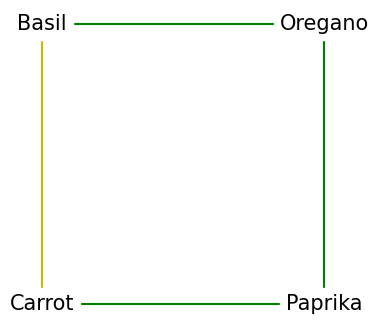

In [14]:
# Making the Hamiltonian in its full form and getting the lowest eigenvalue and eigenvector
ee = NumPyMinimumEigensolver()
result = ee.compute_minimum_eigenvalue(qubitOp)

print("Minimized objective:", result.eigenvalue.real + offset)

x_exact = sample_most_likely(result.eigenstate)
obj_exact = qp.objective.evaluate(x_exact)
print("Solution:", x_exact)
print("Solution objective:", obj_exact)

model.plot_solution(x_exact)

Here you have the opportunity to compare the obtained solutions with the ones you might have computed earlier with the "brute-force" method.

### Quantum computer

Quantum computing offers an alternative algorithm to estimate the lowest eigenstates of the Ising Hamiltonian - the quantum variational eigensolver with the QAOA variational ansatz. Besides the variational ansatz, the algorithm requires the specification of a classical local optimizer (`opt=COBYLA()`), which is used to optimize the circuit parameters $\beta$ and $\gamma$. The QAOA solutions are known to be extremely sensitive to the choice of the starting point. To speed up the optimization procedure, we provide a "good" starting point for the tutorial problem that quickly leads to a correct solution.

The Qiskit's Aer provider contains a variety of high performance simulator backends for a variety of simulation methods. The available backends on the current system can be viewed using `Aer.backends`. We choose the shot-based quantum computer simulator and set the seed value of the random number generator for reproducibility.

In [15]:
seed = 12345
algorithm_globals.random_seed = seed

backend = Aer.get_backend("qasm_simulator")

n_shots = 129
quantum_instance = QuantumInstance(
    backend, seed_simulator=seed, seed_transpiler=seed, shots=n_shots
)

In [16]:
%%time

p = 1

# to visualize the optimization history
counts = []
values = []
def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean+offset)
    
initial_point = [0.5, -0.25]
    
opt = COBYLA(maxiter=100)
qaoa = QAOA(
    optimizer=opt, reps=p, 
    quantum_instance=quantum_instance, 
    initial_point=initial_point, 
    callback=store_intermediate_result,
)

out = qaoa.compute_minimum_eigenvalue(qubitOp)
opt_params = list(out.optimal_parameters.values())

print()
print("Expectation value: {0:.4f}".format(out.eigenvalue.real + offset))
print("Optimal parameters (β, γ): {0}".format(opt_params))
print()


Expectation value: 10.4806
Optimal parameters (β, γ): [0.49651511135633736, -0.1393277148118707]

CPU times: user 19.2 s, sys: 23.6 s, total: 42.8 s
Wall time: 14.1 s


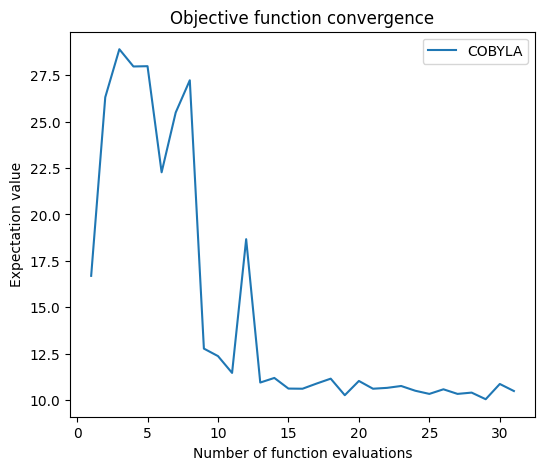

In [17]:
plt.figure(figsize=(6, 5))
plt.plot(counts, values, label=type(opt).__name__)
plt.xlabel("Number of function evaluations")
plt.ylabel("Expectation value")
plt.title("Objective function convergence")
plt.legend()
plt.show()

Let us discuss the workflow and output of the QAOA optimization procedure. When using the shot-based simulator, the QAOA algorithm generates `n_shots` binary strings, each of which could be considered as a candidate solution. 
On the classical backend, the objective values are computed for each string. The expectation value (mean objective) is used to optimize the variational parameters following the instructions of the local classical optimization algorithm. The quantum/classical optimization procedure terminates after satisfying the stopping criteria (`maxiter`).

The main output of the QAOA optimization procedure is a list of variational parameters/angles. We use these angles to setup the optimized QAOA variational ansatz and sample the final state from it.

In [18]:
def sampling(
    ansatz, params, n_shots=128, backend=Aer.get_backend("qasm_simulator"), seed=12345
):
    qc = ansatz.copy()
    qc.measure_all()

    job = execute(
        qc.assign_parameters(parameters=params),
        backend,
        shots=n_shots,
        seed_simulator=seed,
        seed_transpiler=seed,
    )
    counts = job.result().get_counts()

    sols = []
    for s, p in counts.items():
        x = np.asarray([int(y) for y in reversed(list(s))])
        obj = qp.objective.evaluate(x)
        sols.append({"x": x, "prob": p / n_shots, "obj": obj, "feas": model.is_feasible(x)})

    return sols


def plot_solutions(dict_sols, exact, show_feasible=False, sort_obj=True):
    """Visualize the QAOA solutions.
    
    Args:
        dict_sols: dictionary {"label": solutions_dict, ...} of data for visualization
        exact: reference value for the objective function
        show_feasible: highlight the feasible solutions
        sort_obj: sort the objective function values
    """
    fig, ax = plt.subplots(1, 2, figsize=(11, 5))

    for label, sol in dict_sols.items():
        if sort_obj:
            sol = sorted(sol, key=lambda d: d["obj"])
        
        x = [s["obj"] for s in sol]
        y = [s["prob"] for s in sol]
        z = [s["feas"] for s in sol]

        ax[0].plot(x)
        ax[0].set_xlabel("Samples")
        ax[0].set_ylabel("Objective")

        ax[1].bar(x, y, width=0.5, label=label)
        if show_feasible:
            x_feas, y_feas = [], []
            for _x, _y, _z in zip(x, y, z):
                if _z:
                    x_feas.append(_x)
                    y_feas.append(_y)
            if len(x_feas):
                ax[1].bar(x_feas, y_feas, width=1.0, label=label + " (feas)", color="green", fill=False, lw=3, edgecolor="green")
        ax[1].set_xlabel("Objective")
        ax[1].set_ylabel("Quasi probability")
    
    # exact solution
    ax[0].axhline(y=exact, ls=":", color='k')
    ax[1].axvline(x=exact, ls=":", color='k', label='exact')

    plt.legend()
    plt.show()

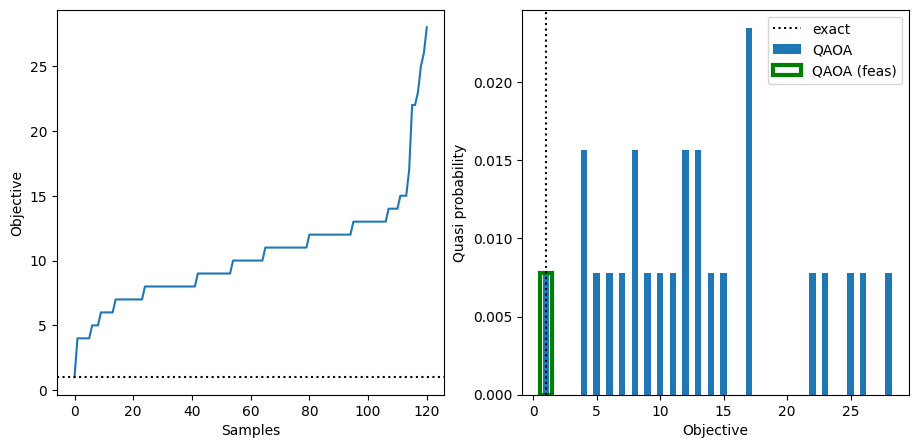

In [19]:
sols = sampling(
    qaoa.ansatz, out.optimal_parameters, backend=backend, n_shots=128, seed=12345
)

plot_solutions({"QAOA": sols}, obj_exact, show_feasible=True)

On the left, we plot the objectives for all output samples. The black dotted line shows the exact value (taken from the exact solver). On the right, we see the quasi probability to find the solution at a given energy. Unlike the exact solver, the QAOA returns multiple solutions in a wide energy interval. With the green bars we mark the "feasible" solutions, i.e. the solution that satisfy all the constraints.

Let us take a closer look at the solutions with the lowest objectives.

In [20]:
print("Lowest objective solutions:")
lowest_obj_solutions = sorted(sols, key=lambda kv: kv["obj"])
for s in lowest_obj_solutions[:8]:
    print(s)

Lowest objective solutions:
{'x': array([1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1]), 'prob': 0.0078125, 'obj': 1.0, 'feas': True}
{'x': array([0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1]), 'prob': 0.0078125, 'obj': 4.0, 'feas': False}
{'x': array([0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0]), 'prob': 0.0078125, 'obj': 4.0, 'feas': False}
{'x': array([1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0]), 'prob': 0.0078125, 'obj': 4.0, 'feas': False}
{'x': array([0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0]), 'prob': 0.0078125, 'obj': 4.0, 'feas': False}
{'x': array([1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0]), 'prob': 0.015625, 'obj': 4.0, 'feas': False}
{'x': array([0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0]), 'prob': 0.0078125, 'obj': 5.0, 'feas': False}
{'x': array([0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1]), 'prob': 0.0078125, 'obj': 5.0, 'feas': False}


The string with the lowest objective value has the same energy as the one obtained earlier with the exact diagonalization. We might notice the exact and QAOA strings differ but having the same objective - the ground state solution is degenerate.

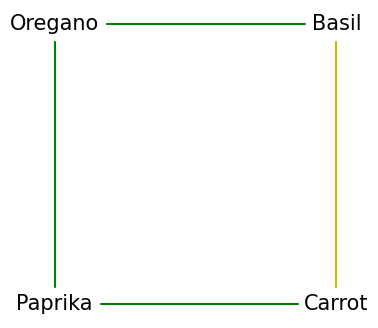

In [21]:
model.plot_solution(lowest_obj_solutions[0]["x"])

As it follows from the plot, the next solution has a higher objective but also a higher sampling probability. Let us examine this solution.

In [22]:
model.plot_solution(lowest_obj_solutions[1]["x"])

Not valid solution!


This sample does not satisfy all the applied problem constraints. Nevertheless, this sample could still be considered as a near optimal solution.

### Energy surface

For `p=1`, one can visualize the cost energy surface as a function of the $\beta$ and $\gamma$ angles.

In [23]:
%%time

N1 = 20
N2 = 10
beta = np.linspace(start=-np.pi, stop=np.pi, num=N1)
gamma = np.linspace(start=-np.pi/2, stop=np.pi/2, num=N2)

e = qaoa.get_energy_evaluation(qubitOp, return_expectation=False)

energy = np.zeros((N1, N2))
for i, b in enumerate(beta):
    for j, g in enumerate(gamma):
        energy[i, j] = e([b, g]) + offset

CPU times: user 2min 2s, sys: 2min 34s, total: 4min 37s
Wall time: 1min 31s


We can plot the energy surface as a heatmap and add the location (cross) of the optimal angles found from the QAOA run above. 

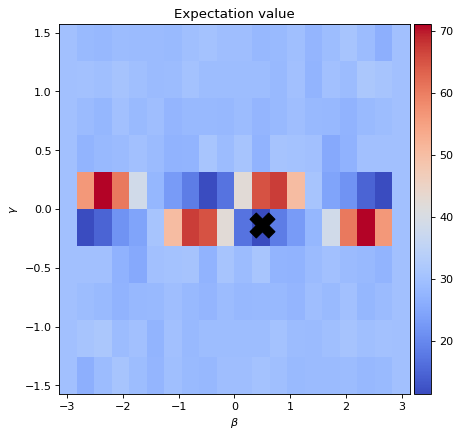

In [24]:
fig = plt.figure(figsize=(6, 6), dpi=80, facecolor="w", edgecolor="k")

X, Y = np.meshgrid(beta, gamma)

ax = plt.gca()
im = ax.imshow(
    energy.T,
    interpolation=None,
    origin="lower",
    extent=[X.min(), X.max(), Y.min(), Y.max()],
    cmap=cm.coolwarm,
    vmax=None,
    aspect="auto",
)
plt.title("Expectation value")
plt.xlabel(r"$\beta$")
plt.ylabel(r"$\gamma$")

ax.scatter(opt_params[0], opt_params[1], marker="X", s=500, c="black")

from mpl_toolkits.axes_grid1 import make_axes_locatable

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
plt.show()

The plot clearly shows us the regions to initialize the optimization parameters in the case of p=1. Note the characteristics of the visualized pattern. Due to the shape of the mixing operator, we can clearly see the periodicity in $\beta$. However, there is no periodicity along $\gamma$. We should always keep this in mind when searching for the optimal parameters.

<font size="4"><span style='background:yellow'>**Exercise:**</span></font> Try to visualize the energy surface in 3D.

<font size="4"><span style='background:yellow'>**Solution:**</span></font> The energy surface in 3d

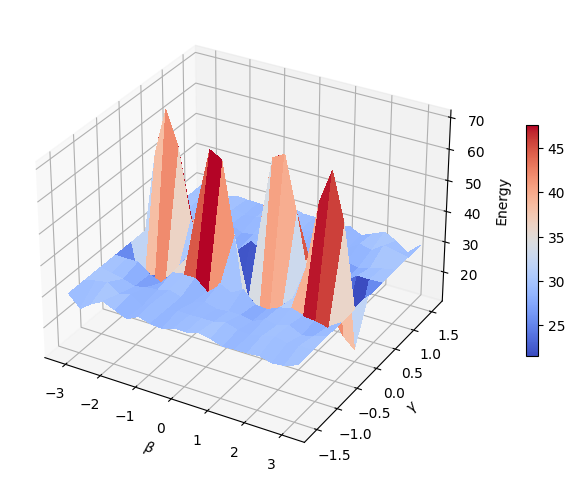

In [25]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(111, projection="3d")

X, Y = np.meshgrid(beta, gamma)
surf = ax.plot_surface(X, Y, energy.T, cmap=cm.coolwarm, linewidth=0, antialiased=False)

fig.colorbar(surf, ax=ax, shrink=0.5, aspect=20)
ax.set_xlabel(r"$\beta$")
ax.set_ylabel(r"$\gamma$")
ax.set_zlabel("Energy")

plt.show()

<font size="4"><span style='background:yellow'>**Exercise:**</span></font> Efficient parameter initialization in QAOA is an active area of research. We offer you to check the QAOA solutions computed with random initializations. Moreover, you could also play with other [local optimizers](https://qiskit.org/documentation/stubs/qiskit.algorithms.optimizers.html) available in Qiskit.

<font size="4"><span style='background:yellow'>**Solution:**</span></font> Let us try to initialize the QAOA circuit with a random guess for $\beta$ and $\gamma$.

In [26]:
%%time

p = 1

np.random.seed(42)
initial_point = np.random.uniform(-np.pi, np.pi, size=2*p)

opt = COBYLA(maxiter=100)
qaoa = QAOA(
    optimizer=opt, reps=p, quantum_instance=quantum_instance, initial_point=initial_point,
)

out = qaoa.compute_minimum_eigenvalue(qubitOp)

print()
print("Problem objective: {0:.4f}".format(out.eigenvalue.real + offset))
print("Optimal parameters (β, γ): {0}".format(list(out.optimal_parameters.values())))
print()


Problem objective: 25.3643
Optimal parameters (β, γ): [-0.8696402662044646, 2.929697857644058]

CPU times: user 10.4 s, sys: 19.9 s, total: 30.3 s
Wall time: 5.87 s


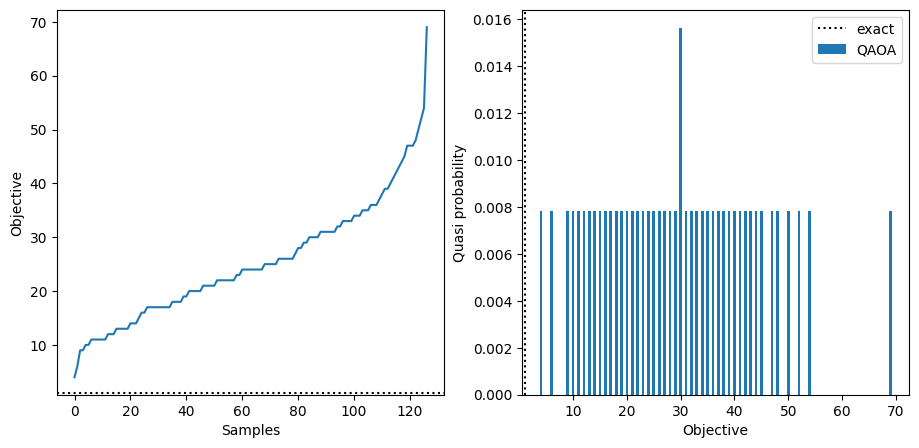

In [27]:
sols = sampling(
    qaoa.ansatz, out.optimal_parameters, backend=backend, n_shots=128, seed=12345
)

plot_solutions({"QAOA": sols}, obj_exact, show_feasible=True)

In [28]:
print("Lowest objective solutions:")
lowest_obj_solutions = sorted(sols, key=lambda kv: kv["obj"])
for s in lowest_obj_solutions[:8]:
    print(s)

Lowest objective solutions:
{'x': array([1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1]), 'prob': 0.0078125, 'obj': 4.0, 'feas': False}
{'x': array([0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0]), 'prob': 0.0078125, 'obj': 6.0, 'feas': False}
{'x': array([1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0]), 'prob': 0.0078125, 'obj': 9.0, 'feas': False}
{'x': array([0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0]), 'prob': 0.0078125, 'obj': 9.0, 'feas': False}
{'x': array([1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0]), 'prob': 0.0078125, 'obj': 10.0, 'feas': False}
{'x': array([1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0]), 'prob': 0.0078125, 'obj': 10.0, 'feas': False}
{'x': array([0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0]), 'prob': 0.0078125, 'obj': 11.0, 'feas': False}
{'x': array([0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0]), 'prob': 0.0078125, 'obj': 11.0, 'feas': False}


In [29]:
model.plot_solution(lowest_obj_solutions[0]["x"])

Not valid solution!


With the random initialization the optimization algorithm ends up with different optimal parameters leading to not optimal (not valid) solutions.

What if we choose a different local minimum solver? Please note that gradient-based local optimization algorithms, such as L-BFGS or SPSA, would take longer to run.

In [30]:
%%time

from qiskit.algorithms.optimizers import NELDER_MEAD, L_BFGS_B, SPSA

p = 1

np.random.seed(42)
initial_point = np.random.uniform(-np.pi, np.pi, size=2*p)

opt = SPSA(maxiter=100) # or any other imported optimizer
qaoa = QAOA(
    optimizer=opt, reps=p, quantum_instance=quantum_instance, initial_point=initial_point,
)

out = qaoa.compute_minimum_eigenvalue(qubitOp)

print()
print("Problem objective: {0:.4f}".format(out.eigenvalue.real + offset))
print("Optimal parameters (β, γ): {0}".format(list(out.optimal_parameters.values())))
print()


Problem objective: 28.0233
Optimal parameters (β, γ): [-2.101478176570404, 2.840321741483497]

CPU times: user 1min 19s, sys: 2min 40s, total: 3min 59s
Wall time: 44.7 s


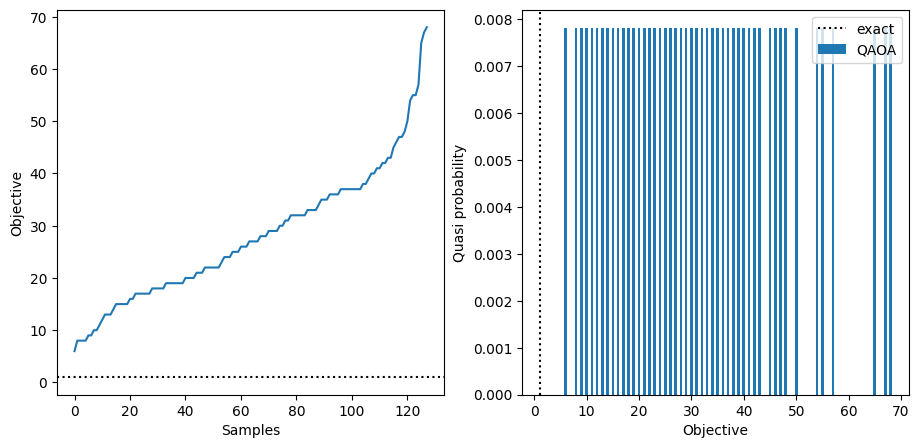

In [31]:
sols = sampling(
    qaoa.ansatz, out.optimal_parameters, backend=backend, n_shots=128, seed=12345
)

plot_solutions({"QAOA": sols}, obj_exact, show_feasible=True)

In [32]:
print("Lowest objective solutions:")
lowest_obj_solutions = sorted(sols, key=lambda kv: kv["obj"])
for s in lowest_obj_solutions[:8]:
    print(s)

Lowest objective solutions:
{'x': array([1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0]), 'prob': 0.0078125, 'obj': 6.0, 'feas': False}
{'x': array([1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0]), 'prob': 0.0078125, 'obj': 8.0, 'feas': False}
{'x': array([0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1]), 'prob': 0.0078125, 'obj': 8.0, 'feas': False}
{'x': array([0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0]), 'prob': 0.0078125, 'obj': 8.0, 'feas': False}
{'x': array([1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]), 'prob': 0.0078125, 'obj': 8.0, 'feas': False}
{'x': array([1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0]), 'prob': 0.0078125, 'obj': 9.0, 'feas': False}
{'x': array([0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]), 'prob': 0.0078125, 'obj': 9.0, 'feas': False}
{'x': array([0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1]), 'prob': 0.0078125, 'obj': 10.0, 'feas': False}


With more advanced local optimizer we still did not manage to find the optimal solutions.

<font size="4"><span style='background:yellow'>**(optional) Exercise:**</span></font> We use the shot-based quantum simulator such that the final state is estimated statistically by setting the number of shots (`n_shots`).
Therefore, it is also interesting to check the influence of `n_shots` on the output of the QAOA algorithm.

In [33]:
p = 1
    
initial_point = [0.5, -0.25]
    
opt = COBYLA(maxiter=100)
qaoa = QAOA(
    optimizer=opt, reps=p, 
    quantum_instance=quantum_instance, 
    initial_point=initial_point, 
    callback=store_intermediate_result,
)
out = qaoa.compute_minimum_eigenvalue(qubitOp)

sols_128 = sampling(
    qaoa.ansatz, out.optimal_parameters, backend=backend, n_shots=128, seed=12345
)
sols_512 = sampling(
    qaoa.ansatz, out.optimal_parameters, backend=backend, n_shots=512, seed=12345
)
sols_1024 = sampling(
    qaoa.ansatz, out.optimal_parameters, backend=backend, n_shots=1024, seed=12345
)

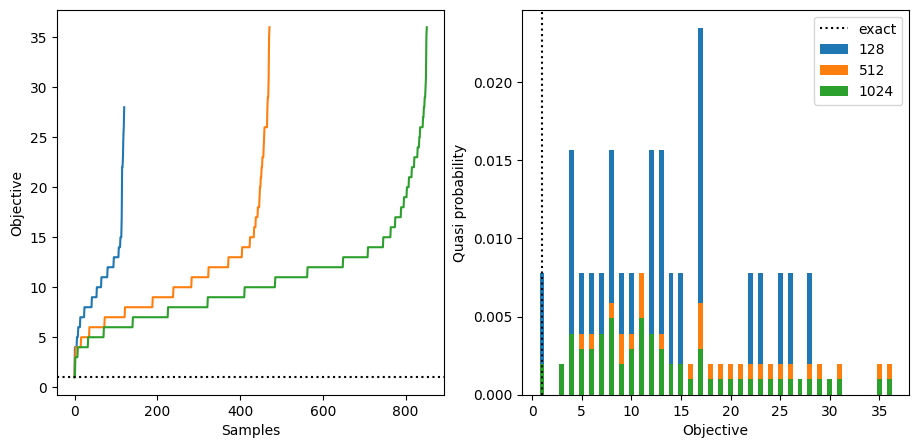

In [34]:
plot_solutions({"128": sols_128, "512": sols_512, "1024": sols_1024}, obj_exact)

Effect of the sampling size on the optimization procedure.

In [35]:
from collections import Counter


def execute_QAOA(
    p=1,
    optimizer=COBYLA(maxiter=100),
    n_shots=128,
    n_runs=1,
    initial_point=None,
    seed=None,
):
    if n_runs == 1:
        _seeds = [seed]
    else:
        np.random.seed(seed)
        _seeds = np.random.randint(2**16, size=n_runs)

    counts = Counter({})
    for _seed in _seeds:
        algorithm_globals.random_seed = _seed
        backend = Aer.get_backend("qasm_simulator")
        quantum_instance = QuantumInstance(
            backend, seed_simulator=_seed, seed_transpiler=_seed, shots=n_shots
        )

        if initial_point is None:
            np.random.seed(_seed)
            initial_point = np.random.uniform(-np.pi, np.pi, size=2 * p)

        qaoa = QAOA(
            reps=p,
            optimizer=optimizer,
            quantum_instance=quantum_instance,
            initial_point=initial_point,
        )

        out = qaoa.compute_minimum_eigenvalue(qubitOp)

        print("--> Running with seed=", _seed)
        print("Problem objective: {0:.4f}".format(out.eigenvalue.real + offset))
        print(
            "Optimal parameters (β, γ): {0}".format(
                list(out.optimal_parameters.values())
            )
        )
        print()

        # collect samples
        qc = qaoa.ansatz.copy()
        qc.measure_all()

        job = execute(
            qc.assign_parameters(parameters=out.optimal_parameters),
            backend,
            shots=n_shots,
            seed_simulator=_seed,
            seed_transpiler=_seed,
        )
        counts += Counter(job.result().get_counts())

    solutions = []
    for s, p in counts.items():
        x = np.asarray([int(y) for y in reversed(list(s))])
        obj = qp.objective.evaluate(x)
        solutions.append({"x": x, "prob": p / n_shots, "obj": obj, "feas": model.is_feasible(x)})

    return solutions

In [36]:
p = 1
initial_point = [0.5, -0.25]

sols_128 = execute_QAOA(p=p, n_shots=128, initial_point=initial_point, seed=12345)
sols_512 = execute_QAOA(p=p, n_shots=512, initial_point=initial_point, seed=12345)
sols_1024 = execute_QAOA(p=p, n_shots=1024, initial_point=initial_point, seed=12345)

--> Running with seed= 12345
Problem objective: 11.4141
Optimal parameters (β, γ): [0.5627517954041688, -0.12731304500737484]

--> Running with seed= 12345
Problem objective: 10.4648
Optimal parameters (β, γ): [0.5265653762492641, -0.14338121042012295]

--> Running with seed= 12345
Problem objective: 9.8965
Optimal parameters (β, γ): [0.4607862536449587, -0.13449418786946743]



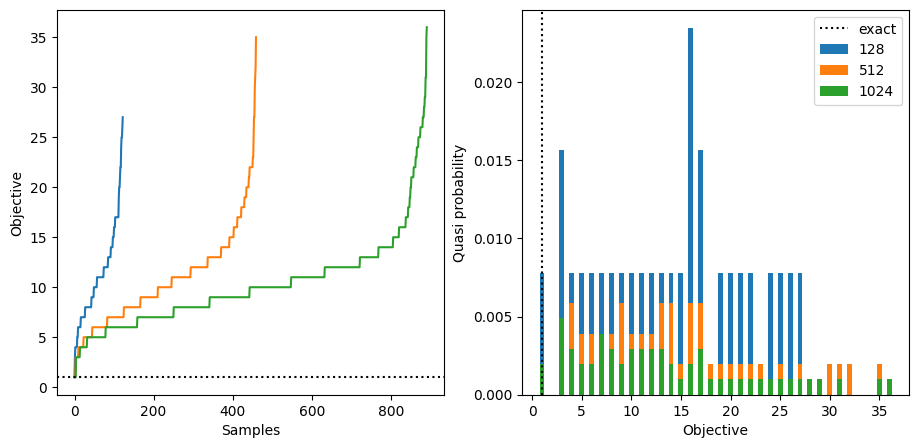

In [37]:
plot_solutions({"128": sols_128, "512": sols_512, "1024": sols_1024}, obj_exact)

<font size="4"><span style='background:yellow'>**Exercise:**</span></font> Above we were trying to find problem solutions with the simplest `p=1` QAOA ansatz. Could you examine what happpens when you increase `p`?

<font size="4"><span style='background:yellow'>**Solution:**</span></font> Let us examine the effect of increasing the number of the variational parameters.

In [38]:
%%time

p = 4

opt = COBYLA(maxiter=100)

initial_point = [0.5, -0.25] * p

# np.random.seed(42)
# initial_point = np.random.uniform(-np.pi, np.pi, size=2*p)

qaoa = QAOA(
    optimizer=opt, reps=p, quantum_instance=quantum_instance, initial_point=initial_point,
)

out = qaoa.compute_minimum_eigenvalue(qubitOp)

print()
print("Problem objective: {0:.4f}".format(out.eigenvalue.real + offset))
print("Optimal parameters (β, γ): {0}".format(list(out.optimal_parameters.values())))
print()

sols_p4 = sampling(
    qaoa.ansatz, out.optimal_parameters, backend=backend, n_shots=128, seed=12345
)


Problem objective: 9.1163
Optimal parameters (β, γ): [1.641858306160851, -0.8313448779252847, -0.049150168223186574, -0.3635482391466904, 0.32324457680745444, -0.380827371810443, 0.2907314118680573, -0.5113966260192391]

CPU times: user 49.2 s, sys: 1min 17s, total: 2min 7s
Wall time: 24.1 s


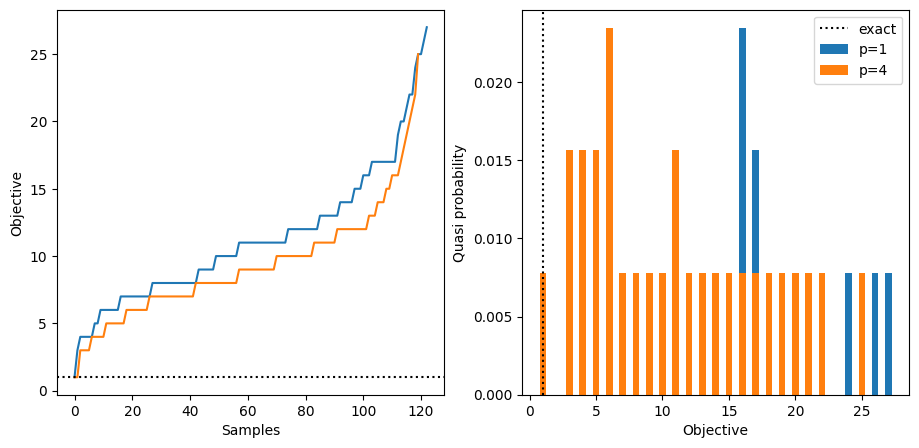

In [39]:
plot_solutions({"p=1": sols_128, "p=4": sols_p4}, obj_exact)

Increasing the QAOA circuit depth has an important effect that helps to improve the solutions. As we could see, the solver concentrates the samples in the low energy region. As a result, we might expect to incease the probability to find an optimal solution. Note, however, that the initialization of the QAOA parameters was not random! The success of the QAOA search would still be strongly influenced by the initialization strategy [[4]](#ref).

## Other topics discussed in this course

In this notebook, we have covered how to solve the Garden Optimization Problem using the Quantum Approximate Optimization Algorithm (QAOA). We used the Qiskit quantum developement toolkit to setup the quantum variational ansatz and the computational workflow to emulate the quantum computer.

To go deeper into a topic how to formulate the Garden Optimization Problem and encode it into an Quadratic Unconstrained Binary Optimization (QUBO) problem, please check the tutorial ["Garden Optimization Problems"](https://jugit.fz-juelich.de/qip/springschool2023/-/blob/main/garden_DWAVE/garden_DWAVE.ipynb). In that tutorial you will also learn how to find solutions using an alternative quantum optimization algorithm and how to execute it on the D-Wave Quantum Annealer.

Another example of a "real-world" optimization problem is presented in the ["Knapsack problem"](https://jugit.fz-juelich.de/qip/springschool2023/-/blob/main/knapsack_QAOA/knapsack-qaoa.ipynb) tutorial. 
There, you can further practice deriving the optimization problem in the QUBO formulation and using the Qiskit quantum development toolkit to implement the QAOA algorithm.

Another very famous example of the real and challenging optimization problem is studied in the tutorial ["Travelling Salesperson Problem"](https://jugit.fz-juelich.de/qip/springschool2023/-/tree/main/tsp_DWAVE). This tutorial will introduce you to the exciting world of the Quantum Annealers.

## <a class="anchor" id="ref"> </a>References

[1] Gonzalez Calaza, C. D.; Willsch, D.; Michielsen, K. Garden Optimization Problems for Benchmarking Quantum Annealers. Quantum Inf Process 2021, 20 (9), 305. https://doi.org/10.1007/s11128-021-03226-6.

[2] Edward Farhi, Jeffrey Goldstone, and Sam Gutmann. "A quantum approximate optimization algorithm." [arXiv preprint arXiv:1411.4028 (2014)](https://arxiv.org/abs/1411.4028).

[3] https://qiskit.org/documentation/optimization/

[4] Zhou, L. et al., Quantum Approximate Optimization Algorithm: Performance, Mechanism, and Implementation on Near-Term Devices. Phys. Rev. X 2020, 10 (2), 021067. https://doi.org/10.1103/PhysRevX.10.021067.

In [40]:
import qiskit.tools.jupyter

%qiskit_version_table